In [563]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [564]:
from load_data import load_data,class_breakdown

In [565]:
data_name ="EEG"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data EEG
batch size:16
train data (9958, 117, 14),(9958, 1)
test data (4905, 117, 14),(4905, 1)


In [566]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=5466, percentage=54.891
Class=2, total=4492, percentage=45.109
Class=1, total=2675, percentage=54.536
Class=2, total=2230, percentage=45.464


In [567]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (9958, 2)
y test shape: (4905, 2)


## 데이터 정규화

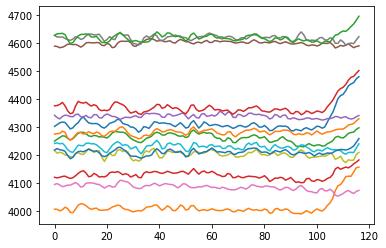

In [568]:
plt.plot(trainx[0])

In [569]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

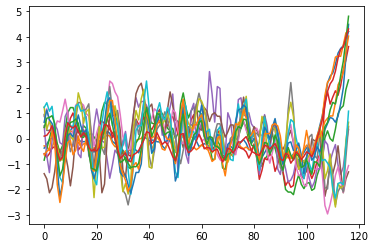

In [570]:
plt.plot(trainx[0])

In [571]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(9958, 1, 117, 14)
trainY shape:(9958, 2)
validX shape:(2452, 1, 117, 14)
validY shape:(2452, 2)
testX shape:(2453, 1, 117, 14)
testY shape:(2453, 2)


In [572]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 117
input_channel 14


# 2. Training condition 정의

In [573]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-4

In [574]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [575]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_last_conv_turnoff,CNN_MC_dropout_input_turnoff

In [576]:
import tensorflow as tf

In [792]:
class basic_CNN:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.prediction,1),tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 64, [1,8], padding='SAME')
            self.pooling1 = tf.layers.max_pooling2d(inputs=self.conv1, pool_size=[1, 4],padding="SAME", strides=2)
            self.batch1 = tf.layers.batch_normalization(self.pooling1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 128, [1,5], padding='SAME')
            self.pooling2 = tf.layers.max_pooling2d(inputs=self.conv2, pool_size=[1, 4] ,padding="SAME", strides=2)                                        
            self.batch2 = tf.layers.batch_normalization(self.pooling2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 256, [1,3], padding='SAME')
            self.pooling3 = tf.layers.max_pooling2d(inputs=self.conv3, pool_size=[1, 4] ,padding="SAME", strides=2)   
            self.batch3 = tf.layers.batch_normalization(self.pooling3)
            self.relu3 = tf.nn.relu(self.batch3)
            self.dropout3 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            self.flatten = tf.reshape(self.relu3, [-1, 12 * 256]) 
            self.dense1 = tf.layers.dense(inputs=self.flatten,
                                     units=128, activation=tf.nn.relu)   
            #Global Average Pooling
            #self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.dense1,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_conv_output(self, conv_output,data, keep_prob,is_dropout):
        conv_output =  self.sess.run((conv_output), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return conv_output
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

In [793]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

2


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [794]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
#MC_dropout_model =CNN_MC_dropout_input_turnoff(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

MC_dropout_model =basic_CNN(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

#MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [795]:
print (MC_dropout_model.input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pooling1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pooling2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pooling3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.flatten)
print (MC_dropout_model.dense1)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 117, 14), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer1/max_pooling2d/MaxPool:0", shape=(?, 1, 59, 64), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 59, 64), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 59, 64), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 59, 64), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 59, 128), dtype=float32)
Tensor("layer2/max_pooling2d/MaxPool:0", shape=(?, 1, 30, 128), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 30, 128), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 30, 128), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 30, 128), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 30, 256), dtype=float32)
Tensor("layer3/max_pooling2d/MaxPool:0", shape=(?, 1, 15, 256), dtyp

# 4. Training

In [796]:
import time
import os
import numpy as np

In [797]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_basic_standardized_dropout_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16


In [798]:
from training import get_batch

In [799]:
keep_prob =0.5

In [685]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/1.ckpt
  training loss:	0.676990
  training acc:	0.568
  validation loss:	0.653358
  validation acc:	0.611
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/2.ckpt
  training loss:	0.643682
  training acc:	0.618
  validation loss:	0.633887
  validation acc:	0.646
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/3.ckpt
  training loss:	0.620518
  training acc:	0.643
  validation loss:	0.62

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/25.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/25.ckpt
  training loss:	0.338492
  training acc:	0.849
  validation loss:	0.384363
  validation acc:	0.820
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/26.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/26.ckpt
  training loss:	0.336365
  training acc:	0.849
  validation loss:	0.358162
  validation acc:	0.837
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/27.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/27.ckpt
  training loss:	0.332479
  training acc:	0.852
  validation loss

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/49.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/49.ckpt
  training loss:	0.226668
  training acc:	0.904
  validation loss:	0.292384
  validation acc:	0.878
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/50.ckpt
  training loss:	0.216012
  training acc:	0.910
  validation loss:	0.265783
  validation acc:	0.885
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/51.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/51.ckpt
  training loss:	0.214411
  training acc:	0.910
  validation loss

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/73.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/73.ckpt
  training loss:	0.151353
  training acc:	0.940
  validation loss:	0.249130
  validation acc:	0.899
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/74.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/74.ckpt
  training loss:	0.151068
  training acc:	0.942
  validation loss:	0.254544
  validation acc:	0.895
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/75.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/75.ckpt
  training loss:	0.147265
  training acc:	0.940
  validation loss

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/97.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/97.ckpt
  training loss:	0.109107
  training acc:	0.958
  validation loss:	0.204352
  validation acc:	0.916
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/98.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/98.ckpt
  training loss:	0.110358
  training acc:	0.957
  validation loss:	0.225893
  validation acc:	0.909
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/99.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/99.ckpt
  training loss:	0.101211
  training acc:	0.960
  validation loss

  training loss:	0.084214
  training acc:	0.970
  validation loss:	0.242897
  validation acc:	0.909
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/121.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/121.ckpt
  training loss:	0.074984
  training acc:	0.973
  validation loss:	0.247728
  validation acc:	0.920
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/122.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/122.ckpt
  training loss:	0.076410
  training acc:	0.971
  validation loss:	0.224919
  validation acc:	0.918
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/123.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/144.ckpt
  training loss:	0.061180
  training acc:	0.978
  validation loss:	0.219249
  validation acc:	0.924
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/145.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/145.ckpt
  training loss:	0.061023
  training acc:	0.978
  validation loss:	0.208198
  validation acc:	0.923
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/146.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/146.ckpt
  training loss:	0.061603
  training acc:	0.977
  validation loss:	0.216392
  validation acc:	0.923
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/147.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/168.ckpt
  training loss:	0.046231
  training acc:	0.982
  validation loss:	0.200904
  validation acc:	0.933
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/169.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/169.ckpt
  training loss:	0.047717
  training acc:	0.983
  validation loss:	0.174663
  validation acc:	0.937
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/170.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/170.ckpt
  training loss:	0.054912
  training acc:	0.979
  validation loss:	0.177193
  validation acc:	0.931
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/171.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/192.ckpt
  training loss:	0.043271
  training acc:	0.985
  validation loss:	0.208792
  validation acc:	0.934
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/193.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/193.ckpt
  training loss:	0.042103
  training acc:	0.985
  validation loss:	0.220000
  validation acc:	0.940
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/194.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/194.ckpt
  training loss:	0.037147
  training acc:	0.985
  validation loss:	0.188106
  validation acc:	0.936
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/195.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/216.ckpt
  training loss:	0.040069
  training acc:	0.985
  validation loss:	0.196631
  validation acc:	0.936
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/217.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/217.ckpt
  training loss:	0.034379
  training acc:	0.987
  validation loss:	0.185300
  validation acc:	0.935
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/218.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/218.ckpt
  training loss:	0.029457
  training acc:	0.990
  validation loss:	0.191843
  validation acc:	0.936
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/219.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/240.ckpt
  training loss:	0.032461
  training acc:	0.989
  validation loss:	0.180796
  validation acc:	0.940
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/241.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/241.ckpt
  training loss:	0.031895
  training acc:	0.988
  validation loss:	0.212497
  validation acc:	0.942
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/242.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/242.ckpt
  training loss:	0.030984
  training acc:	0.989
  validation loss:	0.194191
  validation acc:	0.941
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/243.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/264.ckpt
  training loss:	0.025930
  training acc:	0.991
  validation loss:	0.196316
  validation acc:	0.942
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/265.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/265.ckpt
  training loss:	0.025002
  training acc:	0.991
  validation loss:	0.205527
  validation acc:	0.941
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/266.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/266.ckpt
  training loss:	0.024734
  training acc:	0.991
  validation loss:	0.176664
  validation acc:	0.950
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/267.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/288.ckpt
  training loss:	0.027088
  training acc:	0.990
  validation loss:	0.209225
  validation acc:	0.938
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/289.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/289.ckpt
  training loss:	0.026019
  training acc:	0.990
  validation loss:	0.161384
  validation acc:	0.951
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/290.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/290.ckpt
  training loss:	0.022468
  training acc:	0.993
  validation loss:	0.186440
  validation acc:	0.944
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/291.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/312.ckpt
  training loss:	0.021668
  training acc:	0.993
  validation loss:	0.188989
  validation acc:	0.946
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/313.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/313.ckpt
  training loss:	0.018014
  training acc:	0.994
  validation loss:	0.182178
  validation acc:	0.947
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/314.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/314.ckpt
  training loss:	0.016881
  training acc:	0.994
  validation loss:	0.211135
  validation acc:	0.940
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/315.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/336.ckpt
  training loss:	0.018725
  training acc:	0.994
  validation loss:	0.199239
  validation acc:	0.947
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/337.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/337.ckpt
  training loss:	0.021112
  training acc:	0.994
  validation loss:	0.157299
  validation acc:	0.950
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/338.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/338.ckpt
  training loss:	0.017627
  training acc:	0.993
  validation loss:	0.155797
  validation acc:	0.951
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/339.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/360.ckpt
  training loss:	0.017277
  training acc:	0.993
  validation loss:	0.185107
  validation acc:	0.948
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/361.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/361.ckpt
  training loss:	0.015187
  training acc:	0.995
  validation loss:	0.214966
  validation acc:	0.944
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/362.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/362.ckpt
  training loss:	0.020153
  training acc:	0.993
  validation loss:	0.228996
  validation acc:	0.937
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/363.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/384.ckpt
  training loss:	0.013398
  training acc:	0.995
  validation loss:	0.166584
  validation acc:	0.951
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/385.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/385.ckpt
  training loss:	0.012365
  training acc:	0.996
  validation loss:	0.151033
  validation acc:	0.953
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/386.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/386.ckpt
  training loss:	0.016534
  training acc:	0.994
  validation loss:	0.208800
  validation acc:	0.940
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/387.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/408.ckpt
  training loss:	0.011581
  training acc:	0.995
  validation loss:	0.161357
  validation acc:	0.954
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/409.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/409.ckpt
  training loss:	0.015208
  training acc:	0.994
  validation loss:	0.186523
  validation acc:	0.950
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/410.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/410.ckpt
  training loss:	0.011548
  training acc:	0.996
  validation loss:	0.174136
  validation acc:	0.949
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/411.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/432.ckpt
  training loss:	0.012634
  training acc:	0.995
  validation loss:	0.175811
  validation acc:	0.950
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/433.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/433.ckpt
  training loss:	0.013489
  training acc:	0.995
  validation loss:	0.198005
  validation acc:	0.956
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/434.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/434.ckpt
  training loss:	0.009563
  training acc:	0.997
  validation loss:	0.180624
  validation acc:	0.955
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/435.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/456.ckpt
  training loss:	0.011531
  training acc:	0.996
  validation loss:	0.183196
  validation acc:	0.951
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/457.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/457.ckpt
  training loss:	0.016315
  training acc:	0.994
  validation loss:	0.192378
  validation acc:	0.947
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/458.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/458.ckpt
  training loss:	0.011503
  training acc:	0.996
  validation loss:	0.198727
  validation acc:	0.954
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/459.ckpt is not in all_mod

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/480.ckpt
  training loss:	0.008007
  training acc:	0.998
  validation loss:	0.168409
  validation acc:	0.952
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/481.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/481.ckpt
  training loss:	0.010299
  training acc:	0.997
  validation loss:	0.168208
  validation acc:	0.959
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/482.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/482.ckpt
  training loss:	0.010815
  training acc:	0.996
  validation loss:	0.155928
  validation acc:	0.955
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/483.ckpt is not in all_mod

In [686]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [800]:
from visualization import plot_train_history

In [801]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/loss_graph.png
save ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/acc_graph.png


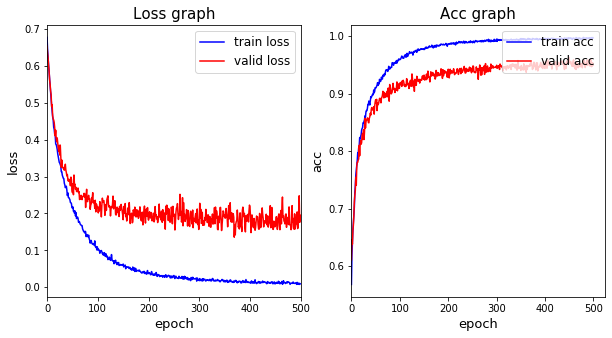

In [802]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [803]:
bestepoch = int(np.argmin(valid_history['loss'].values))
print( bestepoch)

369


In [804]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.13569027635526998


In [805]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/EEG/EEG_CNN_MCdropout_basic_standardized_dropout_0.0001_16/369.ckpt
Model restored


In [806]:
import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+".*")):
        os.remove(filename) 

### with confusion matrix

In [807]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [808]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

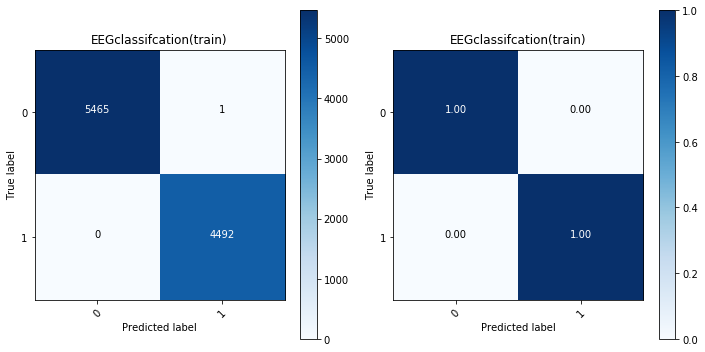

In [696]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

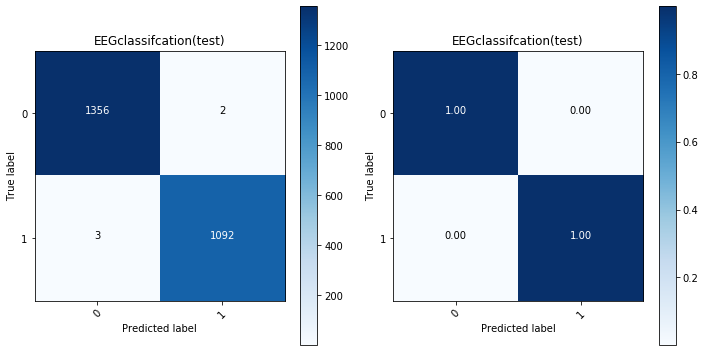

In [697]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
acc를 ~이상 떨어지게 하는 threshold

In [698]:
import random

In [699]:
original_acc = MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False})

In [700]:
conv_output1 = MC_dropout_model.get_conv_output(conv_output = MC_dropout_model.relu1,data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
conv_output2 = MC_dropout_model.get_conv_output(conv_output = MC_dropout_model.relu2,data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
conv_output3 = MC_dropout_model.get_conv_output(conv_output = MC_dropout_model.relu3,data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]

## unit 에 적용할 threshold를 정하고, 각 conv에서 unit끼리의 IOU 수치 구하기

<font color='red'> threshold를 정할 때, 해당 T% 이상인 last convolution activation output을 turnoff 시킬때의 accuracy 변화가 A이상일 때를 기준으로 합니다 </font>

In [701]:
A=5

threshold는 우선 임시로 상위 5%로 정해놓았습니다

In [809]:
threshold1 = np.percentile((conv_output1.flatten()),100 - A)
threshold2 = np.percentile((conv_output2.flatten()),100 - A)
threshold3 = np.percentile((conv_output3.flatten()),100 - A)

In [810]:
conv_bool1 = conv_output1 > threshold1
conv_bool2 = conv_output2 > threshold2
conv_bool3 = conv_output3 > threshold3

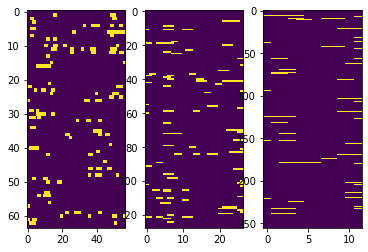

In [811]:
ax = plt.subplot(1,3,1)
ax.imshow(conv_bool1[3].T,aspect='auto')
ax = plt.subplot(1,3,2)
ax.imshow(conv_bool2[0].T,aspect='auto')
ax = plt.subplot(1,3,3)
ax.imshow(conv_bool3[0].T,aspect='auto')

## 패턴 추출

In [823]:
convs_pattern=[]
stride_size=2
pooling_size=4
for data_idx,data in enumerate(trainX[:500,:,:,:]):
    for conv_idx in range(3,4):
        conv_bool = eval("conv_bool"+str(conv_idx))
        for conv_channel in range(conv_bool.shape[2]):
            pattern_highlight_idx = [p for p,x in enumerate(conv_bool[data_idx,:,conv_channel]) if x]
            input_highlight_idx=[np.arange(stride_size*p, (stride_size*p)+pow(pooling_size,conv_idx)) for p in pattern_highlight_idx]
            input_highlight_idx_extend=np.sort(list(set(np.asarray(input_highlight_idx).flatten())))
            groups=[]
            for _, g in groupby(input_highlight_idx_extend, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                for data_channel in range(input_channel):
                    convs_pattern.append({"data_idx":data_idx,"input_channel": data_channel,
                                          "conv_idx":conv_idx,"conv_channel": conv_channel,
                                          "upscaled_pattern_idx":g,  "pattern":data[0,g,data_channel].flatten()})

conv 끼리 모으려면 아래의 코드를 돌리시면 됩니다.

In [824]:
conv1_pattern = [x for x in convs_pattern if x['conv_channel']==1]
conv2_pattern = [x for x in convs_pattern if x['conv_channel']==2]
conv3_pattern = [x for x in convs_pattern if x['conv_channel']==3]

# turn on/off unit

Text(0.5, 0.98, 'ACCURACY WHEN TURN OFF TOP-IMPORTANT NODE IN UNIT ')

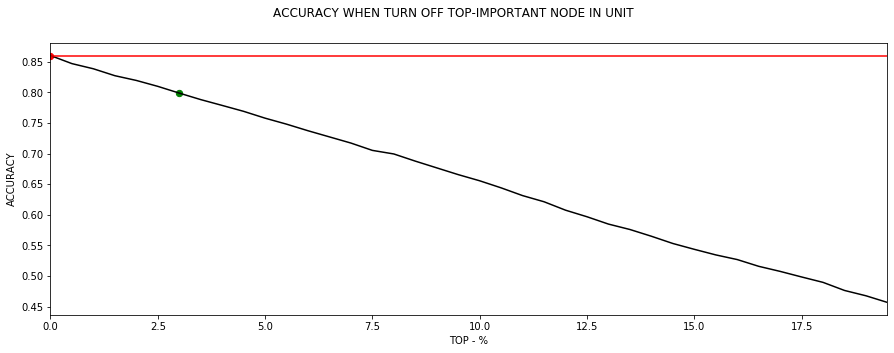

In [91]:
turn_off_acc_list=[original_acc]
threshold = 0
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)

for T in range(995, 800, -5):
    
    temp_threshold = np.percentile(last_conv_output,T/10.0)
    temp_last_conv_bool = last_conv_output>temp_threshold
    threshold_weight = (~temp_last_conv_bool).reshape(-1,1,128,128)
    
    turnoff_acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False,
                                    MC_dropout_model.threshold_weight :threshold_weight})
    
    #print ("[top {}% , threshold: {}]\noriginal acc:{}, turnoff_acc{}".format(100- T/10.0,threshold,original_acc,turnoff_acc))
    acc_difference = original_acc - turnoff_acc
    turn_off_acc_list.append(turnoff_acc)
    if ((acc_difference > A)&(threshold==0)):
        threshold = temp_threshold
        last_conv_bool = temp_last_conv_bool
        ax.scatter(100-(T/10.0),turnoff_acc,s=40,c='green')

ax.scatter(0,original_acc,c='r',s=40)
ax.plot([100- (x/10.0) for x in range(995+5, 800, -5)],turn_off_acc_list,c='black')
ax.axhline(original_acc, c='r')
ax.set_xlabel("TOP - %")
ax.set_ylabel("ACCURACY")

ax.set_xlim(0,100- (T/10.0))
fig.suptitle("ACCURACY WHEN TURN OFF TOP-IMPORTANT NODE IN UNIT ")


# 7.Activated output with threshold
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

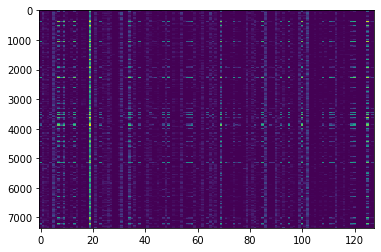

In [92]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

In [93]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

# top unit 끄면서 accuracy 변화보기

In [610]:
def conv_IOU(conv1,conv2_list, previous_mean,num,threshold):
    conv1_bool = conv1>threshold
    conv2_list_bool = conv2_list>threshold
    IOU= [(x==conv1_bool).sum()/len(conv1) for x in conv2_list_bool]
    IOU_mean = [previous+((new-previous)/num) for previous,new in zip(previous_mean,IOU)]

    return IOU_mean

In [611]:
random.seed(1003)
random_data_idx = random.sample(range(conv_output2.shape[0]),500)

In [612]:
conv1_IOU = np.zeros(conv_output1.shape[2]*conv_output1.shape[2]).reshape(conv_output1.shape[2],conv_output1.shape[2])

In [613]:
for conv_c1 in range(conv_output1.shape[2]):
    for num, d_idx in enumerate(random_data_idx):
        conv1_IOU[conv_c1][:]= conv_IOU(conv_output1[d_idx,:,conv_c1],
                                        conv_output1[d_idx,:,:].T,
                                        conv1_IOU[conv_c1][:],
                                        num+1,
                                        threshold1)

high_cov=[]
for conv_c1 in range(conv_output1.shape[2]):
    high_cov_channel = [i for i,x in enumerate (conv1_IOU[conv_c1]>0.98) if (x == True and i!=conv_c1)]
    high_cov.append(high_cov_channel)

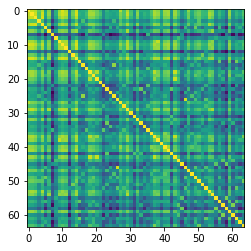

In [614]:
plt.imshow(conv1_IOU)

In [615]:
conv2_IOU = np.zeros(conv_output2.shape[2]*conv_output2.shape[2]).reshape(conv_output2.shape[2],conv_output2.shape[2])

In [616]:
for conv_c1 in range(conv_output2.shape[2]):
    for num, d_idx in enumerate(random_data_idx):
        conv2_IOU[conv_c1][:]= conv_IOU(conv_output2[d_idx,:,conv_c1],
                                        conv_output2[d_idx,:,:].T,
                                        conv2_IOU[conv_c1][:],
                                        num+1,
                                        threshold2)

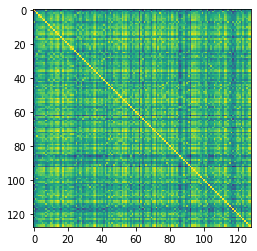

In [617]:
plt.imshow(conv2_IOU)

In [619]:
conv3_IOU = np.zeros(conv_output3.shape[2]*conv_output3.shape[2]).reshape(conv_output3.shape[2],conv_output3.shape[2])

In [620]:
for conv_c1 in range(conv_output3.shape[2]):
    for num, d_idx in enumerate(random_data_idx):
        conv3_IOU[conv_c1][:]= conv_IOU(conv_output3[d_idx,:,conv_c1],
                                        conv_output3[d_idx,:,:].T,
                                        conv3_IOU[conv_c1][:],
                                        num+1,
                                        threshold3)

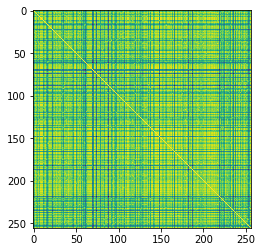

In [621]:
plt.imshow(conv3_IOU)

In [94]:
true_bool=np.ones(trainX.shape[0]*128*128).reshape(-1,1,128,128)
false_bool = np.zeros(trainX.shape[0]*128*128).reshape(-1,1,128,128)

In [95]:
import copy

Text(0.5, 0.98, 'ACCURACY WHEN EACH UNIT IS TURNED OFF ')

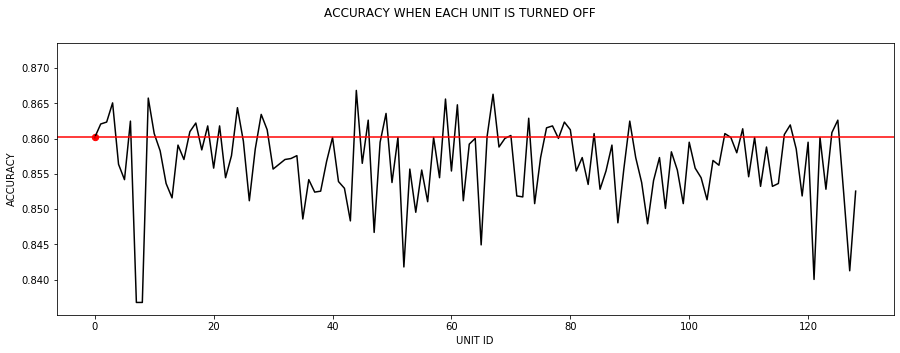

In [97]:
each_turnoff_change=[original_acc]
for i in range(128):
    unit_bool =copy.deepcopy(true_bool)
    unit_bool[:,:,:,i] = False
    
    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False,
                                    MC_dropout_model.threshold_weight :unit_bool})
    each_turnoff_change.append(acc)
    
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1,)
ax.scatter(0,original_acc,c='r',s=40)
ax.plot(each_turnoff_change,c='black')
ax.axhline(original_acc, c='r')
ax.set_xlabel("UNIT ID")
ax.set_ylabel("ACCURACY")
fig.suptitle("ACCURACY WHEN EACH UNIT IS TURNED OFF ")

In [98]:
acc_change_order=np.argsort((original_acc - each_turnoff_change))[::-1]

## turn off

Text(0.5, 0.98, 'ACCURACY WHEN SEVERAL TOP-UNITS ARE TURNED OFF')

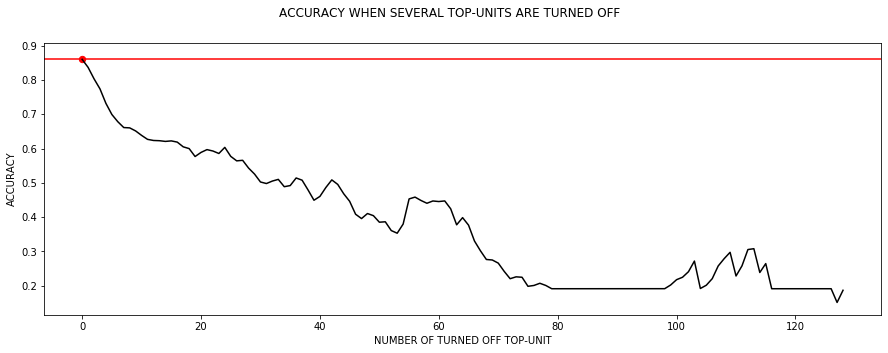

In [140]:
top_turnoff_change=[original_acc]
unit_bool =copy.deepcopy(true_bool)
for unit_idx in acc_change_order:
    if unit_idx==0:
        continue
    unit_bool[:,:,:,unit_idx-1] = False

    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False,
                                    MC_dropout_model.threshold_weight :unit_bool})
    top_turnoff_change.append(acc)   
    
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.scatter(0,original_acc,c='r',s=40)
ax.axhline(original_acc, c='r')
ax.plot(top_turnoff_change,c='black')

ax.set_xlabel("NUMBER OF TURNED OFF TOP-UNIT")
ax.set_ylabel("ACCURACY")
fig.suptitle("ACCURACY WHEN SEVERAL TOP-UNITS ARE TURNED OFF")

Text(0.5, 0.98, 'ACCURACY WHEN SEVERAL UNIMPORTANT-UNITS ARE TURNED OFF')

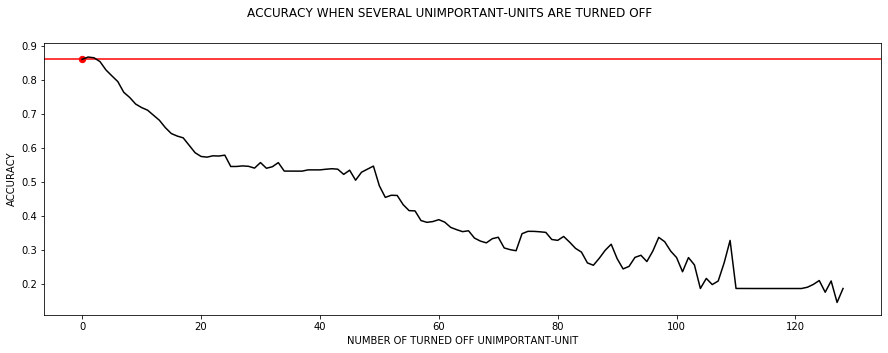

In [137]:
unimportant_turnoff_change=[original_acc]
unit_bool =copy.deepcopy(true_bool)
for unit_idx in acc_change_order[::-1]:
    if unit_idx==0:
        pass
    else:
        unit_bool[:,:,:,unit_idx-1] = False

        acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                              feed_dict={MC_dropout_model.x: trainX,
                                         MC_dropout_model.y: trainY,
                                        MC_dropout_model.keep_prob:1.0,
                                        MC_dropout_model.is_dropout:False,
                                        MC_dropout_model.threshold_weight :unit_bool})
        unimportant_turnoff_change.append(acc)   
        
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.scatter(0,original_acc,c='r',s=40)
ax.axhline(original_acc, c='r')
ax.plot(unimportant_turnoff_change,c='black')

ax.set_xlabel("NUMBER OF TURNED OFF UNIMPORTANT-UNIT")
ax.set_ylabel("ACCURACY")
fig.suptitle("ACCURACY WHEN SEVERAL UNIMPORTANT-UNITS ARE TURNED OFF")

Text(0.5, 0.98, 'ACCURACY WHEN ONLY SEVERAL TOP-UNITS ARE TURNED ON')

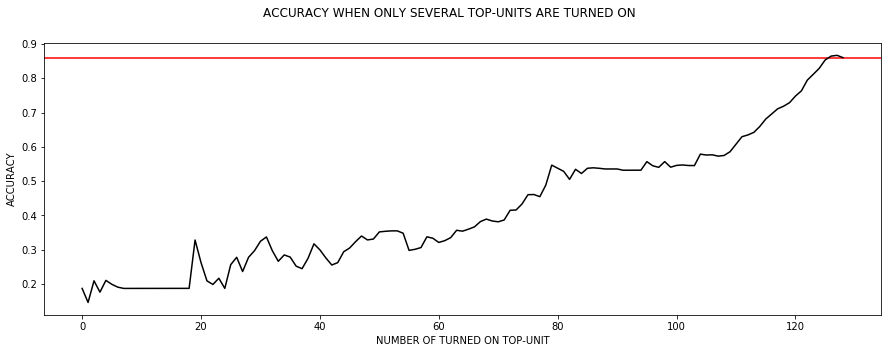

In [138]:
top_turnon_acc =[]

acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                  feed_dict={MC_dropout_model.x: trainX,
                             MC_dropout_model.y: trainY,
                            MC_dropout_model.keep_prob:1.0,
                            MC_dropout_model.is_dropout:False,
                            MC_dropout_model.threshold_weight :false_bool})
top_turnon_acc.append(acc)

unit_bool=copy.deepcopy(false_bool)
for unit_idx in acc_change_order:
    if unit_idx==0:
        pass
    else:
        unit_bool[:,:,:,unit_idx-1] = True
        acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False,
                                    MC_dropout_model.threshold_weight :unit_bool})
        top_turnon_acc.append(acc)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.axhline(original_acc, c='r')
ax.plot(top_turnon_acc,c='black')
ax.set_xlabel("NUMBER OF TURNED ON TOP-UNIT")
ax.set_ylabel("ACCURACY")
fig.suptitle("ACCURACY WHEN ONLY SEVERAL TOP-UNITS ARE TURNED ON")

Text(0.5, 0.98, 'ACCURACY WHEN ONLY SEVERAL UNIMPORTANT-UNITS ARE TURNED ON')

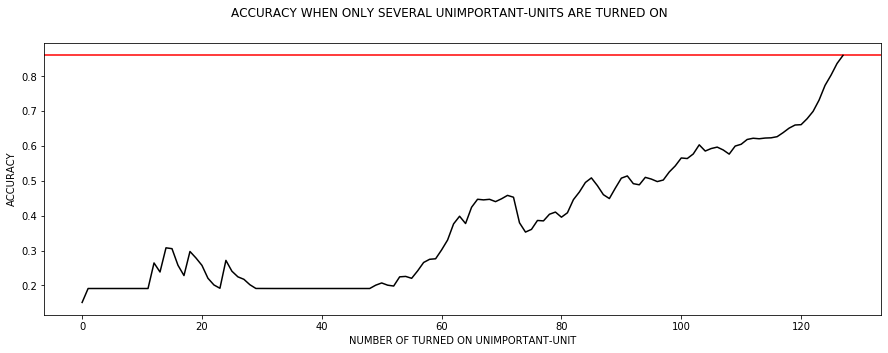

In [139]:
unimportant_turnon_acc =[]
unit_bool=copy.deepcopy(false_bool)
for unit_idx in acc_change_order[::-1]:
    if unit_idx==0:
        continue
    unit_bool[:,:,:,unit_idx-1] = True
    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                      feed_dict={MC_dropout_model.x: trainX,
                                 MC_dropout_model.y: trainY,
                                MC_dropout_model.keep_prob:1.0,
                                MC_dropout_model.is_dropout:False,
                                MC_dropout_model.threshold_weight :unit_bool})
    unimportant_turnon_acc.append(acc)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.axhline(original_acc, c='r')
ax.plot(unimportant_turnon_acc,c='black')
ax.set_xlabel("NUMBER OF TURNED ON UNIMPORTANT-UNIT")
ax.set_ylabel("ACCURACY")
fig.suptitle("ACCURACY WHEN ONLY SEVERAL UNIMPORTANT-UNITS ARE TURNED ON")

## 패턴의 연속성 pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)
## 현재 서버 메모리때문에 trainX 500개까지만 패턴 클러스터링 적용
### 모든 데이터를 위해서는 수정필요

from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [141]:
from itertools import groupby
from operator import itemgetter

In [142]:
consecutive_num =trainX.shape[2]//20
consecutive_num

6

In [143]:
import itertools

In [180]:
input_pattern_channel = 3
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500,:,:,[input_pattern_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        highlight_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if highlight_idx:
            groups = []
            for _, g in groupby(highlight_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    
                    # 같은 데이터의 같은 부분이 패턴으로 인식될 때, repetitive_flag가 TRUE로 변환
                    repetitive_flag=False
                    for x in consecutive_pattern:
                        if (x['data_idx']==data_idx and x['pattern_idx'] == g):
                            x['pattern_channel'].append(output_channel_idx)
                            repetitive_flag=True
                    if not repetitive_flag:
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g].flatten(), "pattern_channel":[output_channel_idx]})

In [181]:
np.unique([len(x['pattern_idx']) for x in consecutive_pattern ])

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,
        72,  73,  74,  75,  76,  77,  79,  80,  82,  83,  88,  90,  91,
        93,  95,  97,  99, 100, 109, 113, 117, 120, 121, 123, 128])

해당 길이 이상의 패턴들을 window slicing 하여 자르는 방법을 이용하실 경우,
밑에 코드를 활성화 하시고, 위에 코드를 주석 처리하시면 됩니다.

step_size=2
input_pattern_channel = 3

pattern_length = 6
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500,:,:,[input_pattern_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        highlight_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if highlight_idx:
            groups = []
            for _, g in groupby(highlight_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=pattern_length:
                    for start_idx in range(0,len(g)-pattern_length+1,step_size):
                        short_pattern_idx = [g[x] for x in range(start_idx, start_idx+pattern_length)]
                        # 같은 데이터의 같은 부분이 패턴으로 인식될 때, repetitive_flag가 TRUE로 변환
                        repetitive_flag=False
                        for x in consecutive_pattern:
                            if (x['data_idx']==data_idx and x['pattern_idx'] == short_pattern_idx):
                                x['pattern_channel'].append(output_channel_idx)
                                repetitive_flag=True
                        if not repetitive_flag:
                            consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":short_pattern_idx, "pattern":data[0,short_pattern_idx].flatten(), "pattern_channel":[output_channel_idx]})

In [182]:
pattern = [(x['pattern']) for x in consecutive_pattern]

In [195]:
from sklearn.neighbors import KernelDensity
from distutils.version import LooseVersion
from scipy.stats import norm
import matplotlib

In [201]:
X=pattern[100]

In [206]:
.shape

(8, 1)

In [203]:
X.shape

(100, 1)

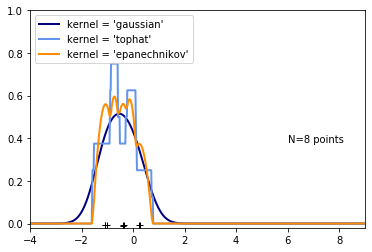

In [208]:
# Plot a 1D density example
N = 8
np.random.seed(1)
X = pattern[100][:,np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
fig, ax = plt.subplots()

colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 1)
plt.show()

In [185]:
kde.score(pattern[0].reshape(-1,1))

-9.610231984586468

In [187]:
len(pattern[300])

13

# clustering

In [148]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [149]:
n_clusters = 6

# clustering with fixed length data

1. 패턴의 길이를 fix하고 해당 length의 패턴만을 클러스터링

In [150]:
pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if len(x['pattern_idx']) ==pattern_len]
specific_pattern=[x['pattern'] for i,x in enumerate(consecutive_pattern) if i in specific_len_pattern_idx]
len(specific_len_pattern_idx)

9589

## pattern standardization
1. 평균0, 분산1 형태로 standardization

In [151]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(specific_pattern)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

(9589, 6)

## spectral clustering, gmm clustering,k-means,SOM

In [152]:
from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

In [153]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "rbf"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 6})
    
]

In [154]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

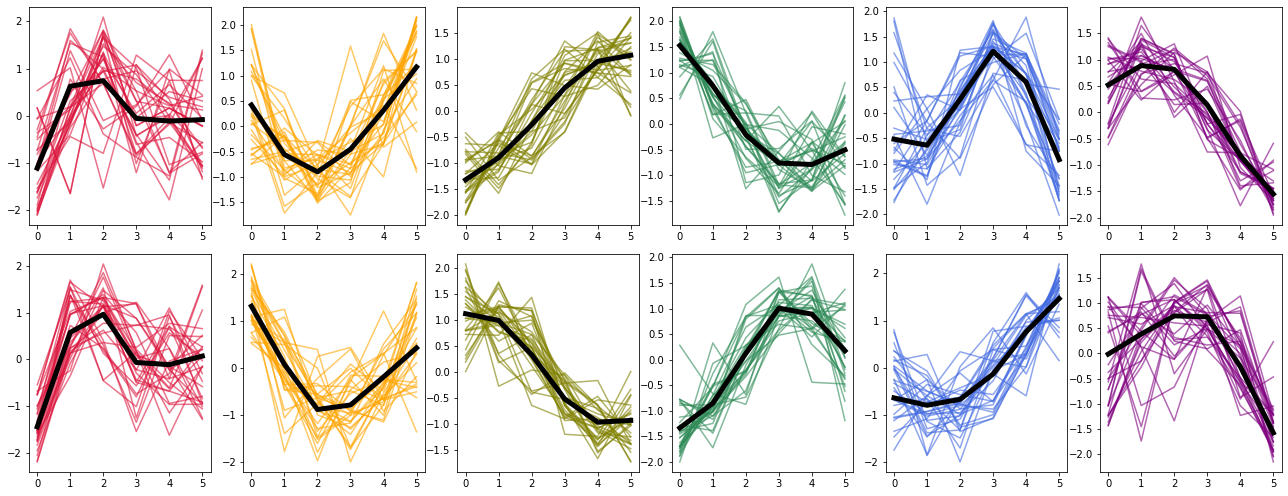

In [155]:
random.seed(300)
for g_option,k_option in zip(gmm_option,kmeans_option):

    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    
    g_cluster_mean_pattern =[]
    k_cluster_mean_pattern =[]

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,7))
    axes = fig.subplots(2, g_params['n_clusters'])
    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]

        try:
            axes[0,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)

        except:
            axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)

        g_cluster_mean = normalized_pattern_candidate[g_class_idx].mean(axis=0)
        g_cluster_mean_pattern.append(g_cluster_mean)
        k_cluster_mean = normalized_pattern_candidate[k_class_idx].mean(axis=0)
        k_cluster_mean_pattern.append(k_cluster_mean)
        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)

    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

In [156]:
import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False,threshold_weight = np.ones(trainX.shape[0]*128*128).reshape(-1,1,128,128))

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx= list(set(specific_data_pattern_idx) & set(specific_len_pattern_idx))
    specific_pattern_info = [consecutive_pattern[x] for x in specific_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==15:
        break
    
    for p_idx,p_info in zip(specific_pattern_idx, specific_pattern_info):
        plot_idx+=1
        # 데이터 자체 그리기
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        data = trainX[d_idx,0,:,input_pattern_channel]
        ax.plot(data,color='black')
        
        highlight_bool = np.zeros(width).astype(bool)
        for p_channel in p_info['pattern_channel']:
            hightlight_bool = (highlight_bool | last_conv_bool[d_idx,:,p_channel])
        
        
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(hightlight_bool) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)

        color_idx = g_pred[specific_len_pattern_idx.index(p_idx)]
        pattern_idx = p_info['pattern_idx']
        ax.plot(pattern_idx, data[pattern_idx], color = color[color_idx])

        # 패턴의 평균값 굵고 투명하게 그리기
        x = g_cluster_mean_pattern[color_idx].reshape(-1,1) #returns a numpy array
        min_max_scaler = MinMaxScaler(feature_range=(data[pattern_idx].min(), data[pattern_idx].max()))
        pattern_scaled = min_max_scaler.fit_transform(x)
        ax.plot(pattern_idx, pattern_scaled, color = color[color_idx], alpha=0.4,linewidth=10)
        fig.suptitle("data{} : label{}, prediction{} \n in last conv output_channel{}".format(d_idx, np.argmax(trainY[d_idx]),np.argmax(prediction[d_idx]),p_info['pattern_channel']),y=1.0)
    plt.show()
    

## clustering with different length scale

#### Global Alignmnet Kernel K Means

In [ ]:
pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern)]
specific_pattern=[x['pattern'] for i,x in enumerate(consecutive_pattern) if i in specific_len_pattern_idx]
len(specific_len_pattern_idx)

In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import GlobalAlignmentKernelKMeans

In [ ]:
#길이를 맞추기위해 nan으로 패딩
X =to_time_series_dataset(specific_pattern)

In [ ]:
gak_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters)
gak_km_predict = gak_km.fit_predict(X)

class_breakdown(gak_km_predict)

In [ ]:
for n in range(n_clusters):
    idx = [i for i,x in enumerate(gak_km_predict) if x==n]
    vars()["pattern_"+str(n)] = [pattern[i] for i in idx ]

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    for p in eval("pattern_"+str(n)):
        ax.plot(range(len(p)),p,color = color[n])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    mindexes = [np.argmax(x) for x in eval("pattern_"+str(n))]
    vars()["norm_pattern_"+str(n)] = [(x-min(x)) for x in eval("pattern_"+str(n))]
    for i,p in enumerate(eval("norm_pattern_"+str(n))):
        shifts = max(mindexes) - mindexes[i]
        ax.plot(range(shifts,shifts+len(p)), p,color=color[n],alpha=0.2)

plt.show()

### find representative shape for each clustering

#### 1. Using U shapelet
ref: Clustering Time Series using Unsupervised-Shapelets

In [ ]:
len(pattern)

In [ ]:
import copy
sLen = range(5,9)
D=copy.deepcopy(pattern)

In [ ]:
S_hat=[]
ts=D[50]
for _ in range(10):
    cnt=0 #count of candidate u-shapelets from ts
    s_hat ={} #set of subsequences, initially empty
    gap = []
    dt =[]
        
    for sl in sLen:#each u-shapelet length
        for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
            s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
            tup = compute_gap(s_hat[cnt],D,6)
            gap.append(tup[0])
            dt.append(tup[1])
            cnt+=1
    if cnt>0:
        index1 = np.argmax(gap)
        S_hat.append(s_hat[index1]) #find maximum gap score
        dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
        try:
            dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True] #points to the left of dt
        except:
            dA = [dis[i] for i,x in enumerate(dis) if x<dt[0]]

        if len(dA) ==1:
            print("dA length:1")
            break
        else:
            index2 = np.argmax(dis)
            ts = D[index2]
            msdA= np.mean(dA) +np.std(dA)
            D_hat = [i for i,x in enumerate(dis<msdA) if x ==True]
            idx = [x for x in np.arange(0,len(D)) if x not in D_hat]
            new_D=[]
            for d_idx in idx:
                new_D.append(D[d_idx])
            D=new_D

In [ ]:
def znorm(data):
    return (data-min(data))/(max(data)-min(data))

In [ ]:
def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

In [ ]:
def compute_gap(sub, data,cluster_num):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1):
        d = (dis[l]+dis[l+1])/2

        dA = dis[dis<d]
        dB = dis[dis>d]
        try:
            r = len(dA)/len(dB)
            if ((1/cluster_num < r) and (1-(1/cluster_num))):
                mA = dA.mean()
                mB = dB.mean()
                sA = dA.std()
                sB = dB.std()
                gap = mB-sB-(mA+sA)
                if gap > maxGap :
                    #print("gap {}".format(gap))
                    maxGap =gap
                    dt =d
        except:
            pass
    return maxGap, dt

In [ ]:
def compute_distance(sub, data):
    dis=[10e3]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]

        for j in range(0, len(ts)-len(sub)):
            z = znorm(ts[j:j+len(sub)])
            d = euclidean_d(z,sub)
            dis[i]= min(d,dis[i])/np.sqrt(len(sub))
        #print(dis[i])
    return dis

#### 2. Use dtw measure

In [ ]:
from dtwalign import dtw

In [ ]:
x = norm_pattern_5[60]
y = norm_pattern_5[0]
res = dtw(x,y)

# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

"""
if you want to calculate only dtw distance (i.e. no need to gain alignment path),
give 'distance_only' argument as True (it makes faster).
"""
#res = dtw(x,y,distance_only=True)

In [ ]:

ax = plt.subplot(2,1,1)
ax.plot(x,color="blue")
ax.plot(y,color="red")
ax.set_ylim(0,1)
# warp both x and y by alignment path
x_path = res.path[:,0]
y_path = res.path[:,1]

ax = plt.subplot(2,1,2)
ax.plot(x[x_path],label="aligned query",color="blue")
ax.plot(y[y_path],label="aligned reference",color="red")
ax.legend()
ax.set_ylim(0,1)

# visualize alignment path with cumsum cost matrix
res.plot_path()

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_info = [consecutive_pattern[x] for x in specific_data_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==5:
        break
    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']== p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_data_pattern_idx[idx]
            color_idx = gak_km_predict[specific_data_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
        break

        
    plt.show()

# Below part is still unclear

f = open('file.txt', 'a+t')
for i,x in enumerate(X):
    for x_ in x:
        f.write(str(x_[0])+",")
    f.write(":"+str(gak_km_predict[i])+"\n")

f.close()      

In [ ]:
X_df = pd.DataFrame(columns=["dim_0"],index=range(len(X)))
for i,x in enumerate(X):
    X_df.iloc[i,0] = x

In [ ]:
Y_df =gak_km_predict.astype('<U1')

In [ ]:
from sktime.transformers.shapelets import ContractedShapeletTransform
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(X_df, Y_df)

In [ ]:
# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(
        X[s.series_id],
        'gray'
    )

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        X[s.series_id,s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

## hierarchical clustering

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

In [ ]:
import matplotlib.patheffects as pe

In [ ]:
random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

# SOM

In [ ]:
import sompy

In [ ]:
som = sompy.SOMFactory.build(normalized_pattern_candidate, mapsize=None, normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose=False)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
from sompy.visualization.hitmap import HitMapView
som.cluster(4)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(som)

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

## represent as feature vector

### 1. wavelet

In [ ]:
import do_wavelet
import matplotlib.gridspec as gridspec
import pywt

In [ ]:
N = normalized_pattern_candidate[3].shape[0]
t0=10
dt=1
time = np.arange(0, N) * dt + t0
signal = normalized_pattern_candidate[3]
 
scales = np.arange(1, 128)

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[:2, 0:5])
bottom_left_ax = fig.add_subplot(spec[2:, 0:5])
bottom_right_ax = fig.add_subplot(spec[2:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

### 2. clustering time series using unsupervised shapelets

In [ ]:
D =pattern.copy(deep=True)
sLen = range(6,32)

S_hat={}
ts =D[500]

In [ ]:
len(pattern)

In [ ]:
s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [ ]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [ ]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [ ]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

In [ ]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [ ]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [ ]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break